In [100]:
from src.dataloader import *
from src.confusion_matrix import make_confusion_matrix
from src.lenet5 import buildModel
from src.tsne import *

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Model
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.manifold import TSNE

# LeNet5: implémentation et apprentissage

## Absence de data augmentations

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. On entraîne le LeNet5 sans data augmentations. Nous fixons les hyper-paramètres de façon arbitraire dans un premier temps:
* Learning rate: 0,01
* Momentum: 0,9
* Dropout: 0,2
* epochs: 10
* batch size: 32

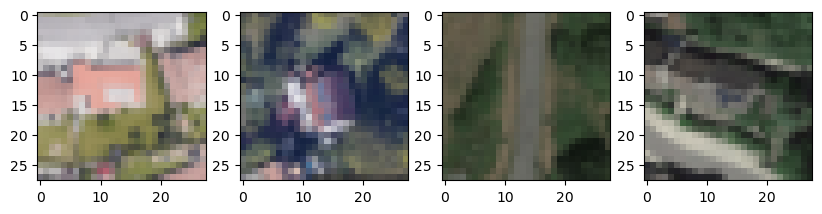

In [30]:
path_train = "C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test = "C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
]))
transformed_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                              transform=transforms.Compose([
                                                  transforms.Resize(28),
                                                  transforms.ToTensor(),
                                              ]))


train_dataloader = DataLoader(
    transformed_train_dataset, batch_size=22907, shuffle=True)
test_dataloader = DataLoader(
    transformed_test_dataset, batch_size=5727, shuffle=True)

X_train, Y_train = next(iter(train_dataloader))
X_test, Y_test = next(iter(test_dataloader))

X_train_permute = X_train.permute(0, 2, 3, 1)
X_test_permute = X_test.permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 4, figsize=(10, 10))

axs[0].imshow(X_train_permute[0].numpy())
axs[1].imshow(X_train_permute[1].numpy())
axs[2].imshow(X_train_permute[2].numpy())
axs[3].imshow(X_train_permute[3].numpy())


In [31]:
model_init = buildModel()

history = model_init.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
                         validation_data=(
                             X_test_permute.numpy(), Y_test.numpy()),
                         batch_size=32,
                         epochs=10)


Epoch 1/10
716/716 [==============================] - 12s 15ms/step - loss: 0.5150 - Accuracy: 0.7634 - recall_m: 0.7850 - precision_m: 0.7791 - f1_m: 0.7712 - f2_m: 0.7770 - val_loss: 0.4442 - val_Accuracy: 0.8210 - val_recall_m: 0.8006 - val_precision_m: 0.8573 - val_f1_m: 0.8227 - val_f2_m: 0.8081
Epoch 2/10
716/716 [==============================] - 10s 14ms/step - loss: 0.4489 - Accuracy: 0.8140 - recall_m: 0.8299 - precision_m: 0.8253 - f1_m: 0.8217 - f2_m: 0.8252 - val_loss: 0.4151 - val_Accuracy: 0.8332 - val_recall_m: 0.8421 - val_precision_m: 0.8474 - val_f1_m: 0.8405 - val_f2_m: 0.8405
Epoch 3/10
716/716 [==============================] - 10s 14ms/step - loss: 0.4275 - Accuracy: 0.8226 - recall_m: 0.8305 - precision_m: 0.8366 - f1_m: 0.8284 - f2_m: 0.8284 - val_loss: 0.3963 - val_Accuracy: 0.8392 - val_recall_m: 0.8730 - val_precision_m: 0.8349 - val_f1_m: 0.8499 - val_f2_m: 0.8627
Epoch 4/10
716/716 [==============================] - 10s 15ms/step - loss: 0.4113 - Accuracy:

Loss sur l'échantillon train: 0.346
Accuracy sur l'échantillon train: 0.863
Recall sur l'échantillon train: 0.854
Precision sur l'échantillon train: 0.883
F1-score sur l'échantillon train: 0.865
F2-score sur l'échantillon train: 0.857
Loss sur l'échantillon test: 0.349
Accuracy sur l'échantillon test: 0.859
Recall sur l'échantillon test: 0.848
Precision sur l'échantillon test: 0.884
F1-score sur l'échantillon test: 0.861
F2-score sur l'échantillon test: 0.852
179/179 [==============================] - 1s 3ms/step
Nombre d'images prédites avec panneaux: 2946
Nombre d'images prédites sans panneau: 2781


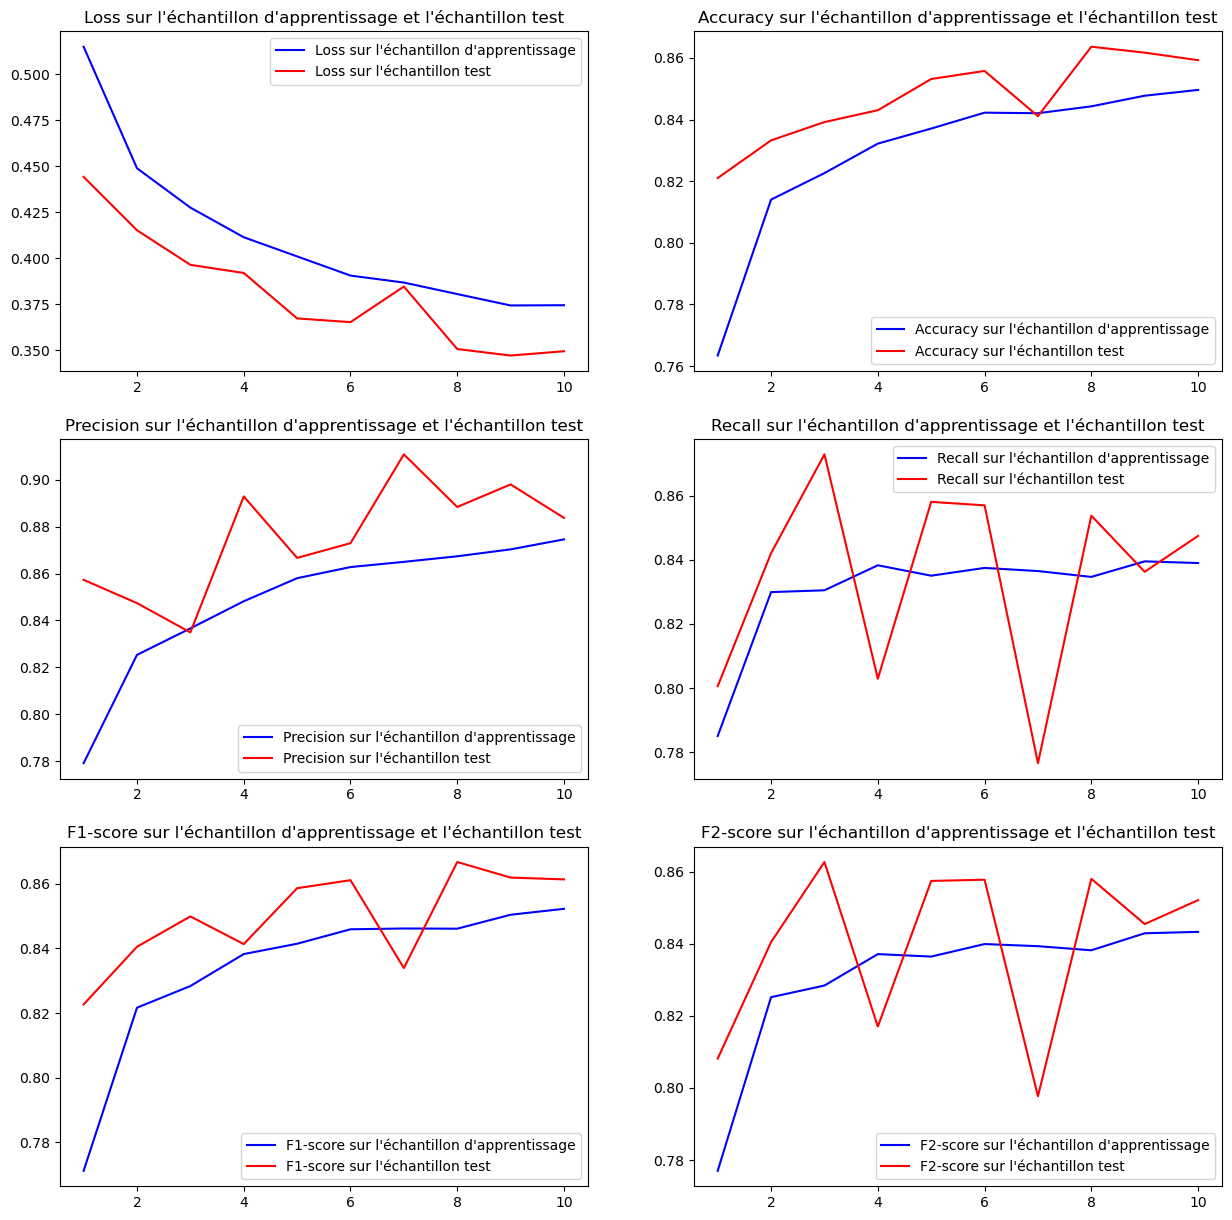

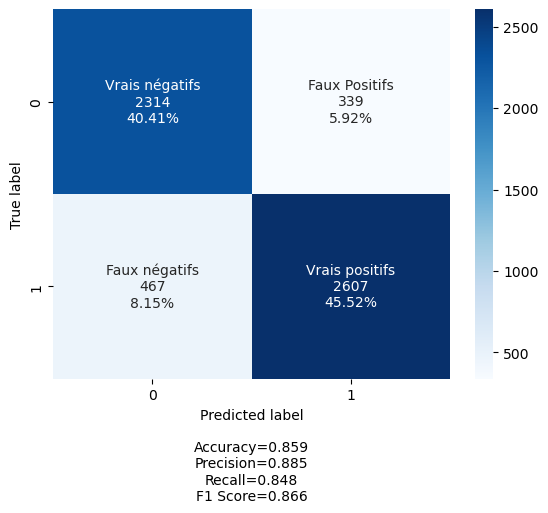

AUC: 0.92


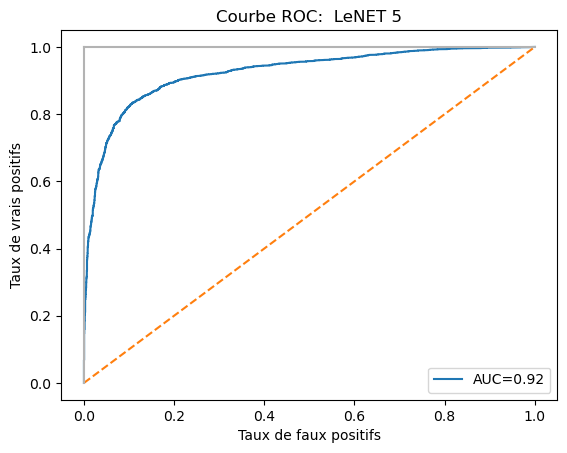

<Figure size 640x480 with 0 Axes>

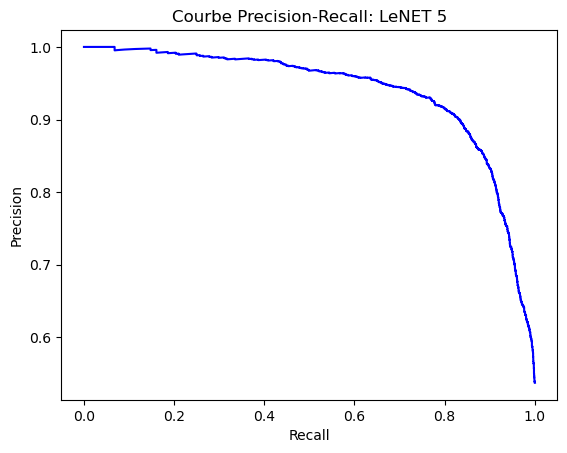

In [32]:
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']

accuracy = history.history['Accuracy']
val_accuracy = history.history['val_Accuracy']

precision = history.history['precision_m']
val_precision = history.history['val_precision_m']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

f2 = history.history['f2_m']
val_f2 = history.history['val_f2_m']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(recall) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs, accuracy, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs, val_accuracy, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs, precision, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs, val_precision, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs, f1, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs, val_f1, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs, f2, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs, val_f2, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()

plt.savefig("loss_lenet5_brut.png")

train_loss, train_accuracy, train_recall, train_precision, train_f1score, train_f2score = model_init.evaluate(
    X_train_permute.numpy(), Y_train.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(train_loss, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(train_accuracy, 3)))
print("Recall sur l'échantillon train: {}".format(round(train_recall, 3)))
print("Precision sur l'échantillon train: {}".format(round(train_precision, 3)))
print("F1-score sur l'échantillon train: {}".format(round(train_f1score, 3)))
print("F2-score sur l'échantillon train: {}".format(round(train_f2score, 3)))

loss, accuracy, recall, precision, f1score, f2score = model_init.evaluate(
    X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score, 3)))

prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

unique, counts = np.unique(y_pred, return_counts=True)
res = dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

r = confusion_matrix(Y_test, y_pred)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      save="confusion_matrix_lenet5_brut.png"
                      )

FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), prob_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()
plt.savefig("ROC_lenet5_brut.png")

prec, rec, thresholds_keras = precision_recall_curve(Y_test.numpy(), prob_predict)

fig, ax = plt.subplots()
ax.plot(rec, prec, color='blue')

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET 5')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig("prec_recall_lenet5_brut.png")
plt.show()

## Ajout de data augmentations (Sans Crop)

Comme les images sont de dimension relativement faible, on ne met pas de crop. De plus, on évite le colorjitter pour ne pas "détruire les images". Enfin,  comme les panneaux sont orientés au nord, on ne met pas de rotations aléatoires. Enfin, on normalise les données d'apprentissage et de test.

In [33]:
transformed_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),

]))

# On resize uniquement sur le test
transformed_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                              transform=transforms.Compose([
                                                  transforms.Resize(28),
                                                  transforms.ToTensor(),
                                              ]))

train_dataloader = DataLoader(
    transformed_train_dataset, batch_size=22907, shuffle=True)
test_dataloader = DataLoader(
    transformed_test_dataset, batch_size=5727, shuffle=True)

mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))


normalized_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train.tolist(),
                         std=std_train.tolist()),


]))


normalize_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                            transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean_test.tolist(),
                                                                     std=std_test.tolist()),
                                            ]))
train_dataloader_augmente = DataLoader(
    normalized_train_dataset, batch_size=22907, shuffle=True)
test_dataloader_augmente = DataLoader(
    normalize_test_dataset, batch_size=5727, shuffle=True)




Moyenne par channel: [0.34678810834884644, 0.3542118966579437, 0.3044023811817169]
Ecart-type par channel: [0.16155807673931122, 0.14244027435779572, 0.1397261619567871]
Moyenne par channel: [0.343392550945282, 0.3513449728488922, 0.3021348714828491]
Ecart-type par channel: [0.16113589704036713, 0.14197203516960144, 0.1393584907054901]


## Apprentissage avec data augmentations

In [34]:
X_train_augmente, Y_train_augmente = next(iter(train_dataloader_augmente))
X_test_augmente, Y_test_augmente = next(iter(test_dataloader_augmente))

X_train_augmente_permute = X_train_augmente.permute(0, 2, 3, 1)
X_test_augmente_permute = X_test_augmente.permute(0, 2, 3, 1)

model_augmente = buildModel()

history_augmente = model_augmente.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
                                      validation_data=(
                                          X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
                                      batch_size=32,
                                      epochs=10)

Epoch 1/10
716/716 [==============================] - 10s 13ms/step - loss: 0.4910 - Accuracy: 0.7765 - recall_m: 0.8136 - precision_m: 0.7790 - f1_m: 0.7905 - f2_m: 0.8028 - val_loss: 0.4199 - val_Accuracy: 0.8245 - val_recall_m: 0.8712 - val_precision_m: 0.8150 - val_f1_m: 0.8381 - val_f2_m: 0.8566
Epoch 2/10
716/716 [==============================] - 9s 13ms/step - loss: 0.4191 - Accuracy: 0.8253 - recall_m: 0.8414 - precision_m: 0.8322 - f1_m: 0.8325 - f2_m: 0.8368 - val_loss: 0.3784 - val_Accuracy: 0.8441 - val_recall_m: 0.8443 - val_precision_m: 0.8626 - val_f1_m: 0.8497 - val_f2_m: 0.8456
Epoch 3/10
716/716 [==============================] - 9s 13ms/step - loss: 0.3988 - Accuracy: 0.8351 - recall_m: 0.8425 - precision_m: 0.8479 - f1_m: 0.8411 - f2_m: 0.8410 - val_loss: 0.3555 - val_Accuracy: 0.8614 - val_recall_m: 0.8620 - val_precision_m: 0.8787 - val_f1_m: 0.8667 - val_f2_m: 0.8630
Epoch 4/10
716/716 [==============================] - 9s 13ms/step - loss: 0.3849 - Accuracy: 0.

Loss sur l'échantillon train: 0.333
Accuracy sur l'échantillon train: 0.862
Recall sur l'échantillon train: 0.831
Precision sur l'échantillon train: 0.901
F1-score sur l'échantillon train: 0.861
F2-score sur l'échantillon train: 0.842
Loss sur l'échantillon test: 0.328
Accuracy sur l'échantillon test: 0.865
Recall sur l'échantillon test: 0.842
Precision sur l'échantillon test: 0.903
F1-score sur l'échantillon test: 0.868
F2-score sur l'échantillon test: 0.851
179/179 [==============================] - 1s 4ms/step
Nombre d'images prédites avec panneaux: 2865
Nombre d'images prédites sans panneau: 2862


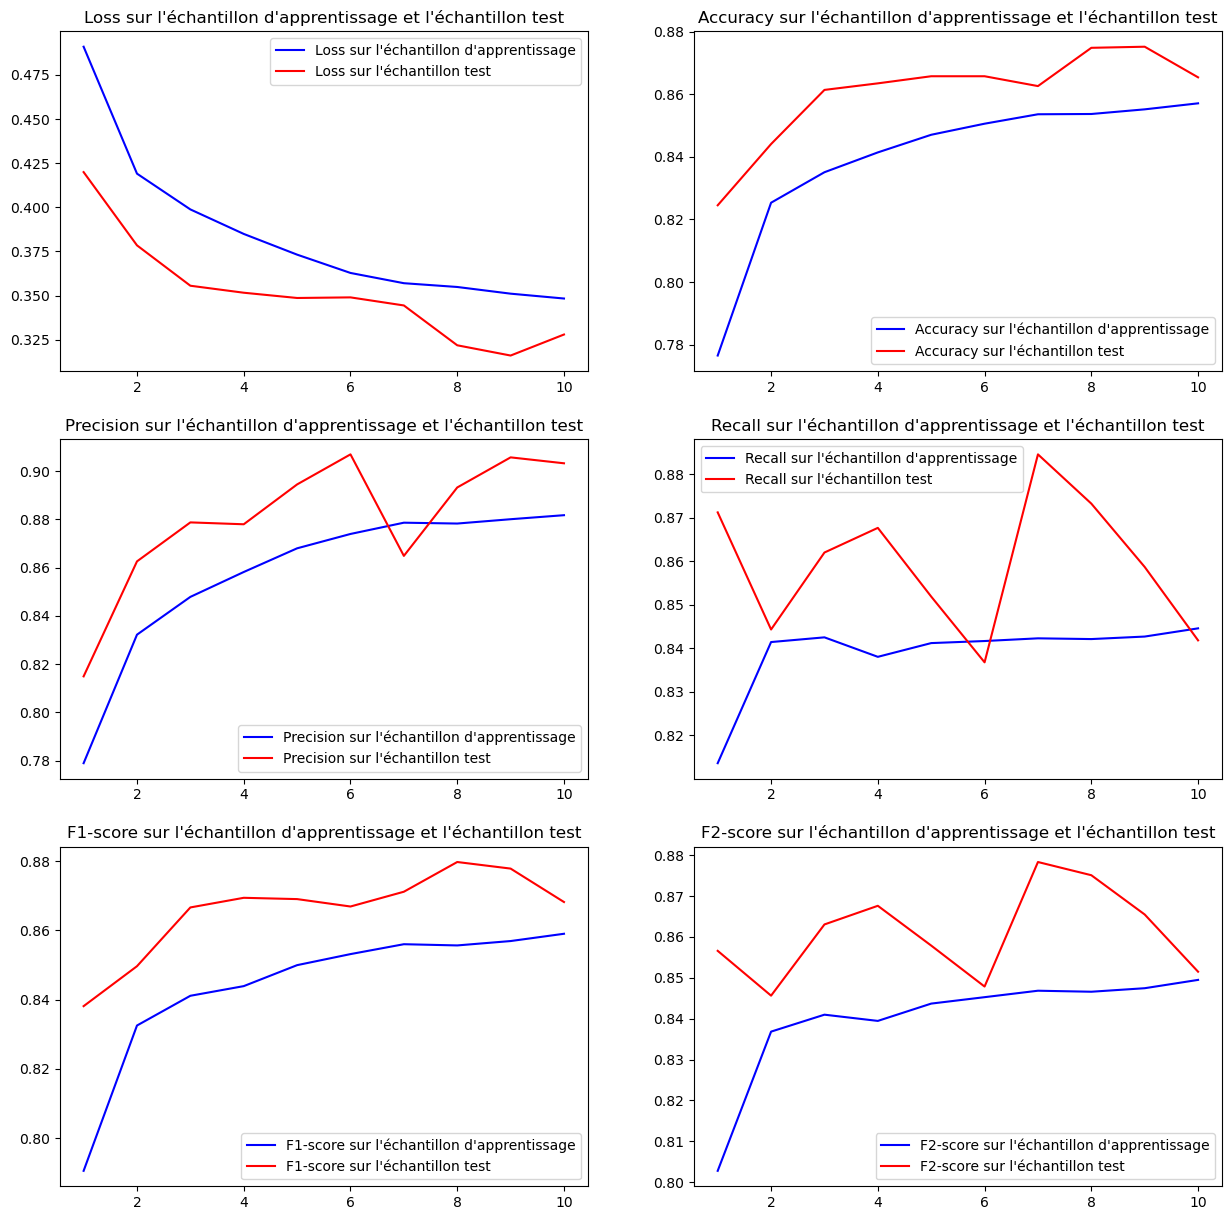

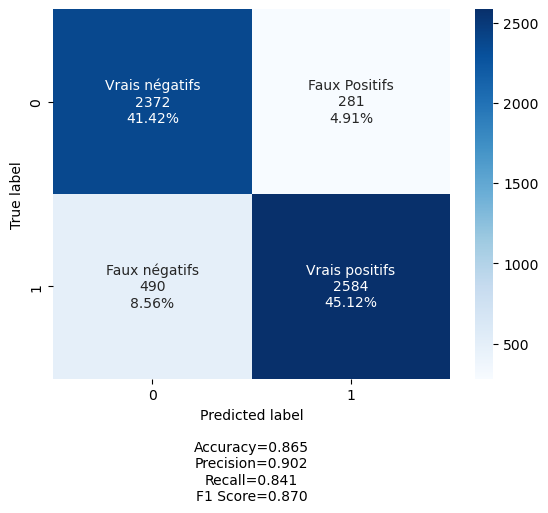

AUC: 0.93


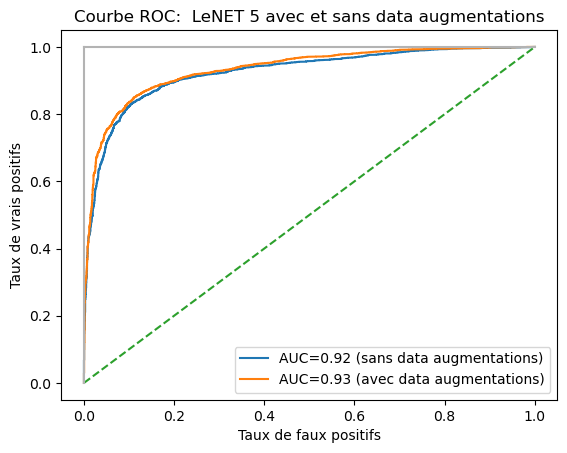

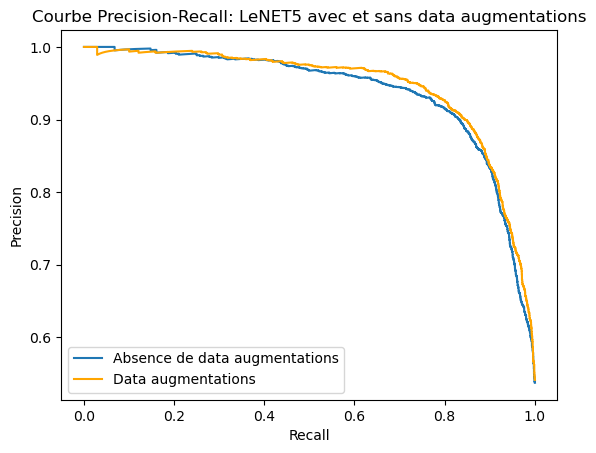

In [35]:
recall_augmente = history_augmente.history['recall_m']
val_recall_augmente = history_augmente.history['val_recall_m']

accuracy_augmente = history_augmente.history['Accuracy']
val_accuracy_augmente = history_augmente.history['val_Accuracy']

precision_augmente = history_augmente.history['precision_m']
val_precision_augmente = history_augmente.history['val_precision_m']

f1_augmente = history_augmente.history['f1_m']
val_f1_augmente = history_augmente.history['val_f1_m']

f2_augmente = history_augmente.history['f2_m']
val_f2_augmente = history_augmente.history['val_f2_m']

loss_augmente = history_augmente.history['loss']
val_loss_augmente = history_augmente.history['val_loss']

epochs_augmente = range(1, len(recall_augmente) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_augmente, loss_augmente, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_augmente, val_loss_augmente, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_augmente, accuracy_augmente, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_augmente, val_accuracy_augmente, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_augmente, precision_augmente, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_augmente, val_precision_augmente, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_augmente, recall_augmente, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_augmente, val_recall_augmente, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_augmente, f1_augmente, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_augmente, val_f1_augmente, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_augmente, f2_augmente, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_augmente, val_f2_augmente, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()

plt.savefig("loss_lenet5_dataaugmentation.png")

loss_augmente_train, accuracy_augmente_train, recall_augmente_train, precision_augmente_train, f1score_augmente_train, f2score_augmente_train = model_augmente.evaluate(
    X_train_augmente_permute.numpy(), Y_train_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_augmente_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_augmente_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_augmente_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_augmente_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_augmente_train, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_augmente_train, 3)))

loss_augmente, accuracy_augmente, recall_augmente, precision_augmente, f1score_augmente, f2score_augmente = model_augmente.evaluate(
    X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_augmente, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_augmente, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_augmente, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_augmente, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_augmente, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_augmente, 3)))

prob_predict_augmente = model_augmente.predict(X_test_augmente_permute.numpy())
y_pred_augmente = (np.squeeze(prob_predict_augmente) > 0.5).astype("int32")

unique_augmente, counts_augmente = np.unique(
    y_pred_augmente, return_counts=True)
res_augmente = dict(zip(unique_augmente, counts_augmente))
print("Nombre d'images prédites avec panneaux: {}".format(res_augmente[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_augmente[0]))

r = confusion_matrix(Y_test_augmente, y_pred_augmente)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      save="confusion_matrix_lenet5_data_augmentations.png"
                      )

FPR_augmente, TPR_augmente, thresholds_keras_augmente = roc_curve(
    Y_test_augmente.numpy(), prob_predict_augmente)
AUC_augmente = auc(FPR_augmente, TPR_augmente)
print("AUC: {}".format(round(AUC_augmente, 2)))

plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.savefig("ROC_lenet5_data_augmentations.png")
plt.show()

prec_augmente, rec_augmente, thresholds_keras = precision_recall_curve(Y_test_augmente.numpy(), prob_predict_augmente)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, color='orange', label="Data augmentations")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.savefig("prec_recall_lenet5_data_agumentations.png")
plt.show()


# Ajout de crop

In [36]:
crop_train_dataset = CustomImageDataset(path_train, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/", transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),
    transforms.RandomCrop(24), #On garde environ 75% de l'image
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train.tolist(),
                         std=std_train.tolist()),


]))


crop_test_dataset = CustomImageDataset(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                            transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean_test.tolist(),
                                                                     std=std_test.tolist()),
                                            ]))
train_dataloader_crop = DataLoader(
    crop_train_dataset, batch_size=22907, shuffle=True)
test_dataloader_crop = DataLoader(
    crop_test_dataset, batch_size=5727, shuffle=True)

In [37]:
X_train_crop, Y_train_crop = next(iter(train_dataloader_crop))
X_test_crop, Y_test_crop = next(iter(test_dataloader_crop))

X_train_crop_permute = X_train_crop.permute(0, 2, 3, 1)
X_test_crop_permute = X_test_crop.permute(0, 2, 3, 1)

model_crop = buildModel()

history_crop= model_crop.fit(x=X_train_crop_permute.numpy(), y=Y_train_crop.numpy(),
                                      validation_data=(
                                          X_test_crop_permute.numpy(), Y_test_crop.numpy()),
                                      batch_size=32,
                                      epochs=10)

Epoch 1/10
716/716 [==============================] - 11s 15ms/step - loss: 0.5297 - Accuracy: 0.7495 - recall_m: 0.7944 - precision_m: 0.7512 - f1_m: 0.7664 - f2_m: 0.7814 - val_loss: 0.4494 - val_Accuracy: 0.7994 - val_recall_m: 0.8942 - val_precision_m: 0.7692 - val_f1_m: 0.8230 - val_f2_m: 0.8631
Epoch 2/10
716/716 [==============================] - 10s 13ms/step - loss: 0.4873 - Accuracy: 0.7791 - recall_m: 0.8085 - precision_m: 0.7837 - f1_m: 0.7907 - f2_m: 0.8000 - val_loss: 0.4264 - val_Accuracy: 0.8167 - val_recall_m: 0.8793 - val_precision_m: 0.7984 - val_f1_m: 0.8333 - val_f2_m: 0.8592
Epoch 3/10
716/716 [==============================] - 9s 13ms/step - loss: 0.4686 - Accuracy: 0.7922 - recall_m: 0.8186 - precision_m: 0.7973 - f1_m: 0.8026 - f2_m: 0.8109 - val_loss: 0.4073 - val_Accuracy: 0.8243 - val_recall_m: 0.8418 - val_precision_m: 0.8320 - val_f1_m: 0.8329 - val_f2_m: 0.8372
Epoch 4/10
716/716 [==============================] - 10s 13ms/step - loss: 0.4559 - Accuracy: 

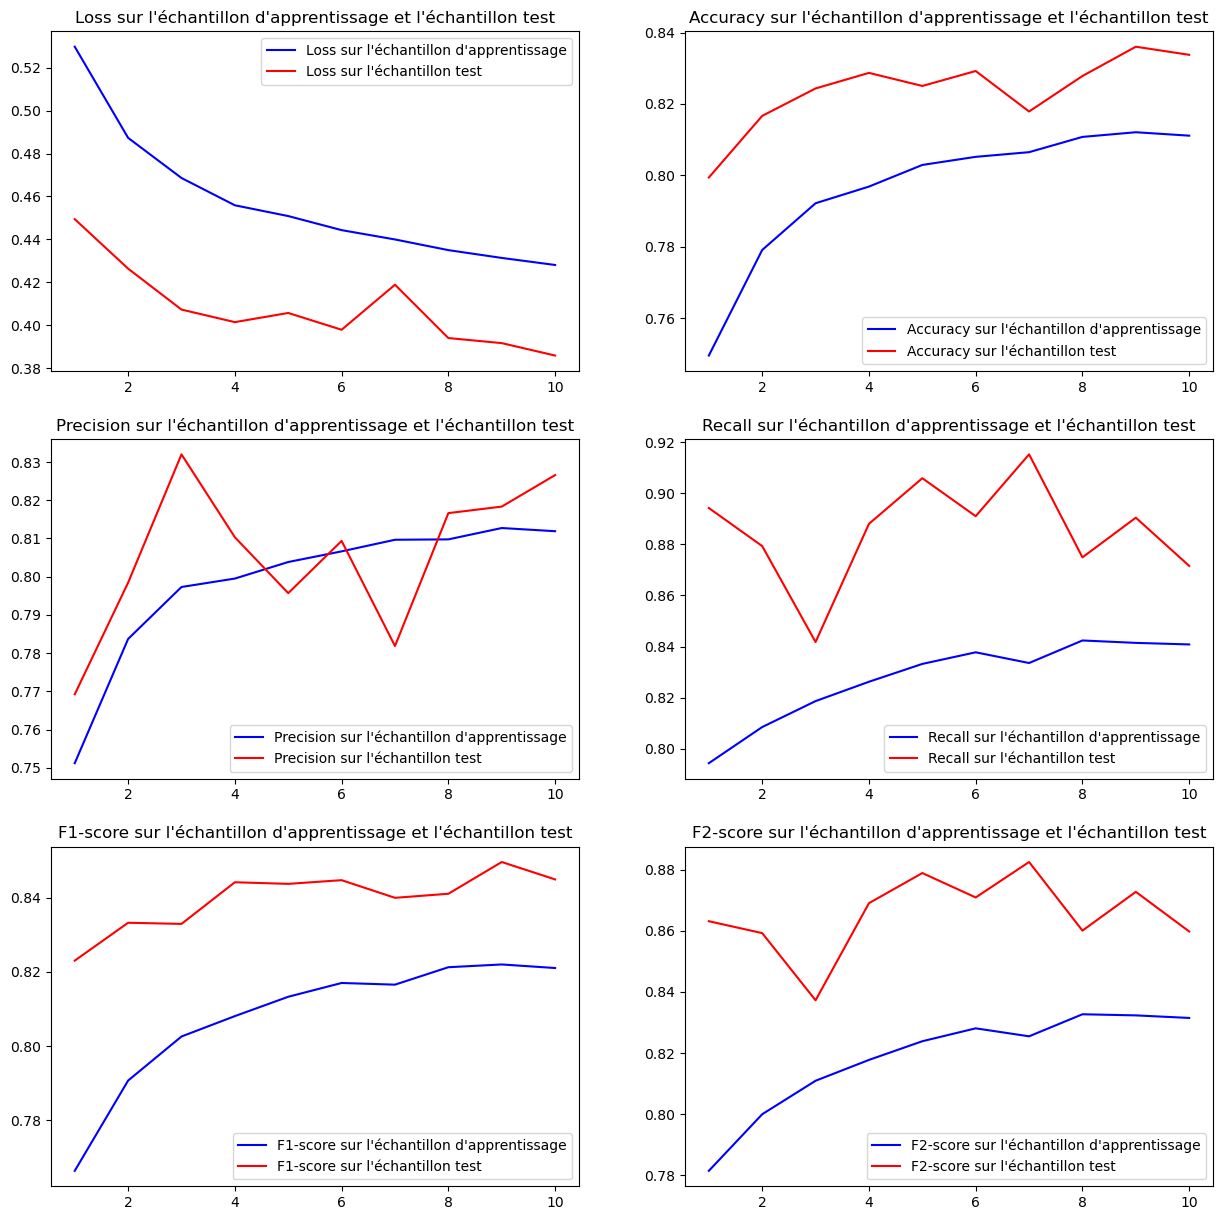

Loss sur l'échantillon train: 0.403
Accuracy sur l'échantillon train: 0.827
Recall sur l'échantillon train: 0.839
Precision sur l'échantillon train: 0.837
F1-score sur l'échantillon train: 0.834
F2-score sur l'échantillon train: 0.836
Loss sur l'échantillon test: 0.386
Accuracy sur l'échantillon test: 0.834
Recall sur l'échantillon test: 0.872
Precision sur l'échantillon test: 0.827
F1-score sur l'échantillon test: 0.845
F2-score sur l'échantillon test: 0.86
179/179 [==============================] - 1s 4ms/step
Nombre d'images prédites avec panneaux: 3242
Nombre d'images prédites sans panneau: 2485


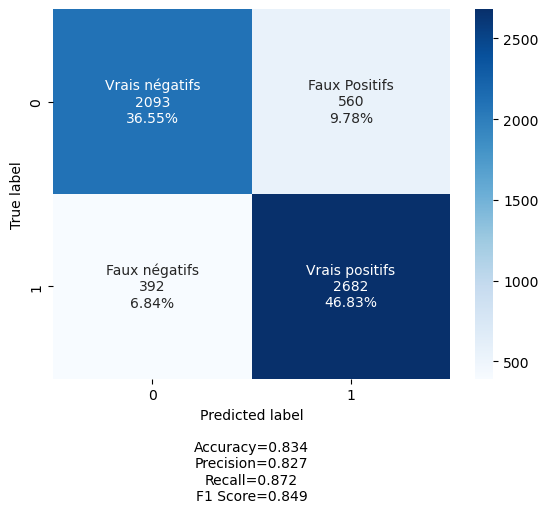

AUC: 0.91


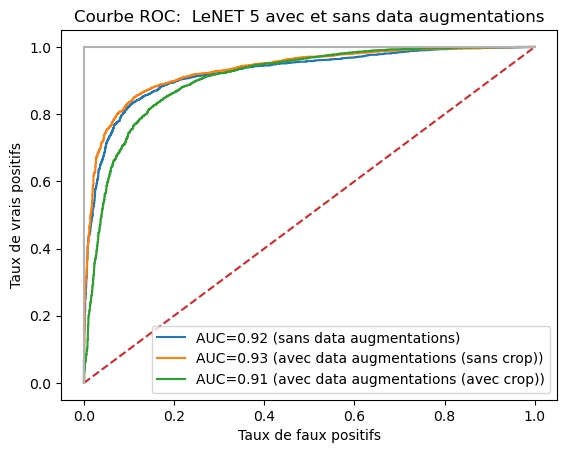

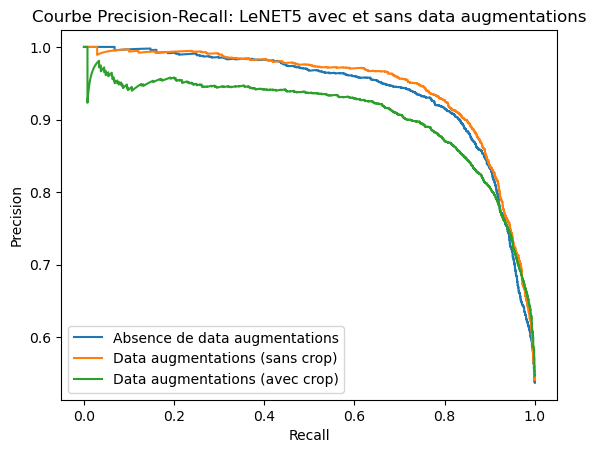

In [38]:
recall_crop = history_crop.history['recall_m']
val_recall_crop = history_crop.history['val_recall_m']

accuracy_crop = history_crop.history['Accuracy']
val_accuracy_crop = history_crop.history['val_Accuracy']

precision_crop = history_crop.history['precision_m']
val_precision_crop = history_crop.history['val_precision_m']

f1_crop = history_crop.history['f1_m']
val_f1_crop = history_crop.history['val_f1_m']

f2_crop = history_crop.history['f2_m']
val_f2_crop = history_crop.history['val_f2_m']

loss_crop = history_crop.history['loss']
val_loss_crop = history_crop.history['val_loss']

epochs_crop= range(1, len(recall_crop) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_crop, loss_crop, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_crop, val_loss_crop, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_crop, accuracy_crop, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_crop, val_accuracy_crop, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_crop, precision_crop, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_crop, val_precision_crop, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_crop, recall_crop, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_crop, val_recall_crop, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_crop, f1_crop, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_crop, val_f1_crop, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_crop, f2_crop, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_crop, val_f2_crop, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()

plt.savefig("loss_lenet5_crop.png")

plt.show()

loss_crop_train, accuracy_crop_train, recall_crop_train, precision_crop_train, f1score_crop_train, f2score_crop_train = model_crop.evaluate(
    X_train_crop_permute.numpy(), Y_train_crop.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_crop_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_crop_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_crop_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_crop_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_crop_train, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_crop_train, 3)))

loss_crop, accuracy_crop, recall_crop, precision_crop, f1score_crop, f2score_crop = model_crop.evaluate(
    X_test_crop_permute.numpy(), Y_test_crop.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_crop, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_crop, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_crop, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_crop, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_crop, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_crop, 3)))

prob_predict_crop = model_crop.predict(X_test_crop_permute.numpy())
y_pred_crop= (np.squeeze(prob_predict_crop) > 0.5).astype("int32")

unique_crop, counts_crop = np.unique(
    y_pred_crop, return_counts=True)
res_crop= dict(zip(unique_crop, counts_crop))
print("Nombre d'images prédites avec panneaux: {}".format(res_crop[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_crop[0]))

r = confusion_matrix(Y_test_crop, y_pred_crop)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      save="confusion_matrix_lenet5_crop.png"
                      )

FPR_crop, TPR_crop, thresholds_keras_crop = roc_curve(
    Y_test_crop.numpy(), prob_predict_crop)
AUC_crop= auc(FPR_crop, TPR_crop)
print("AUC: {}".format(round(AUC_crop, 2)))

plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations (sans crop))")
plt.plot(FPR_crop, TPR_crop, label="AUC=" +
         str(round(AUC_crop, 2))+" (avec data augmentations (avec crop))")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.savefig("ROC_lenet5_crop.png")
plt.show()

prec_crop, rec_crop, thresholds_keras = precision_recall_curve(Y_test_crop.numpy(), prob_predict_crop)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, label="Data augmentations (sans crop)")
ax.plot(rec_crop, prec_crop, label="Data augmentations (avec crop)")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.savefig("prec_recall_lenet5_crop.png")
plt.show()

Même si l'AUC est moins bon, on retient plutôt le modèle avec des crops pour limiter l'over-fitting.

# Hyperparamétrisation du modèle: random search

* n_iter: nombre de combinaisons d'hyperparamètres testées
* cv*n_iter = nombre d'itérations total

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

https://towardsdatascience.com/hyper-parameter-tuning-with-randomised-grid-search-54f865d27926

## Optimisation par rapport au f2-score

On cherche à tomber sur une proportion de 10% des meilleurs paramètres avec une confiance de 95%.

In [39]:
# learnRate = [1e-2, 1e-3, 1e-4]
# momentum = [0.9, 0.99]
# dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# batchSize = [4, 8, 16, 32, 64, 128, 256]
# epochs = [10, 20, 30, 40, 50]

# grid = dict(
#     learnRate=learnRate,
#     momentum=momentum,
#     dropout1=dropout1,
#     dropout2=dropout2,
#     dropout3=dropout3,
#     dropout4=dropout4,
#     batch_size=batchSize,
#     epochs=epochs
# )

# model = KerasClassifier(build_fn=buildModel, verbose=1)
# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# # n_iter: nombre de modèles entrainés
# searcher = RandomizedSearchCV(
#     estimator=model, cv=5, n_iter=30, param_distributions=grid, scoring=ftwo_scorer)
# searchResults = searcher.fit(
#     X_train_crop_permute.numpy(), Y_train_crop.numpy())


In [40]:
# # summarize grid search information
# bestScore_f2 = searchResults.best_score_
# bestParams_f2 = searchResults.best_params_
# print("[INFO] best score is {} using {}".format(round(bestScore_f2, 3),
#                                                 bestParams_f2))

# print(searchResults.cv_results_["mean_test_score"])

## Résultats sur le modèle optimisé

In [41]:
best_model= buildModel(learnRate=0.0001, dropout1=0.3, dropout2=0.8,
                        dropout3=0.8, dropout4=0.9, momentum=0.99)

history_best = best_model.fit(x=X_train_crop_permute.numpy(), y=Y_train_crop.numpy(),
                              validation_data=(
                                  X_test_crop_permute.numpy(), Y_test_crop.numpy()),
                              batch_size=256,
                              epochs=20)


Epoch 1/20
90/90 [==============================] - 6s 61ms/step - loss: 1.4144 - Accuracy: 0.5011 - recall_m: 0.5067 - precision_m: 0.5335 - f1_m: 0.5186 - f2_m: 0.5111 - val_loss: 0.6718 - val_Accuracy: 0.5867 - val_recall_m: 0.5916 - val_precision_m: 0.6210 - val_f1_m: 0.6053 - val_f2_m: 0.5969
Epoch 2/20
90/90 [==============================] - 5s 59ms/step - loss: 1.0548 - Accuracy: 0.5074 - recall_m: 0.5122 - precision_m: 0.5388 - f1_m: 0.5243 - f2_m: 0.5168 - val_loss: 0.6712 - val_Accuracy: 0.6557 - val_recall_m: 0.8059 - val_precision_m: 0.6432 - val_f1_m: 0.7147 - val_f2_m: 0.7666
Epoch 3/20
90/90 [==============================] - 6s 65ms/step - loss: 0.8029 - Accuracy: 0.4999 - recall_m: 0.5296 - precision_m: 0.5306 - f1_m: 0.5294 - f2_m: 0.5293 - val_loss: 0.6879 - val_Accuracy: 0.5558 - val_recall_m: 0.9458 - val_precision_m: 0.5505 - val_f1_m: 0.6955 - val_f2_m: 0.8266
Epoch 4/20
90/90 [==============================] - 5s 57ms/step - loss: 0.7032 - Accuracy: 0.5077 - re

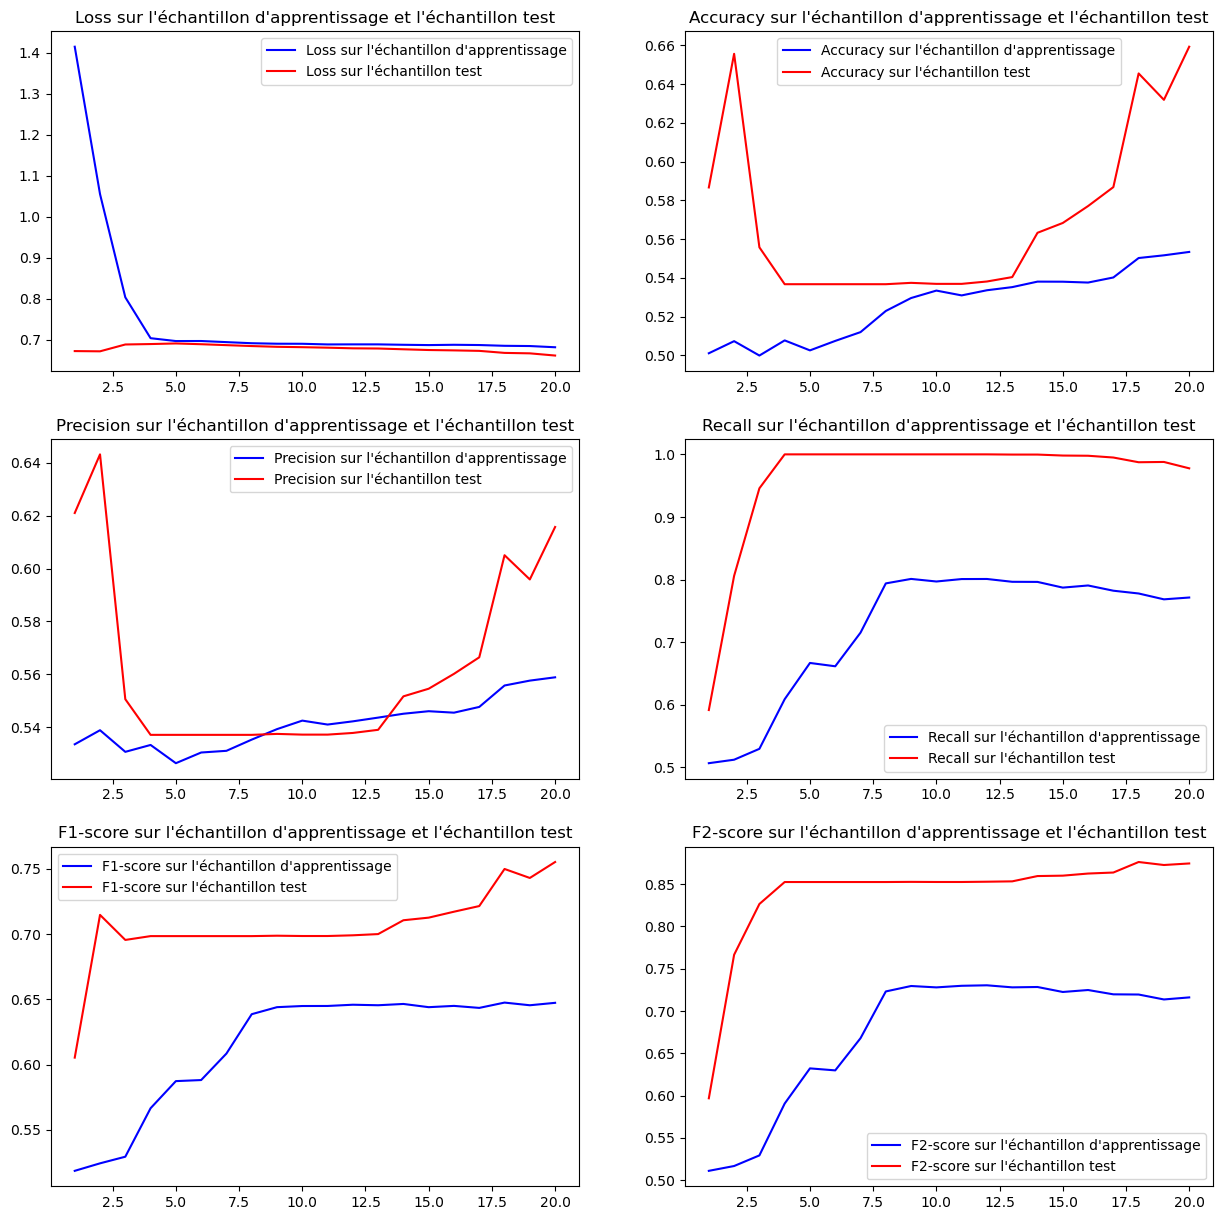

Loss sur l'échantillon train: 0.661
Accuracy sur l'échantillon train: 0.653
Recall sur l'échantillon train: 0.97
Precision sur l'échantillon train: 0.609
F1-score sur l'échantillon train: 0.744
F2-score sur l'échantillon train: 0.863
Loss sur l'échantillon test: 0.661
Accuracy sur l'échantillon test: 0.659
Recall sur l'échantillon test: 0.978
Precision sur l'échantillon test: 0.614
F1-score sur l'échantillon test: 0.751
F2-score sur l'échantillon test: 0.871
179/179 [==============================] - 1s 4ms/step
Nombre d'images prédites avec panneaux: 4891
Nombre d'images prédites sans panneau: 836


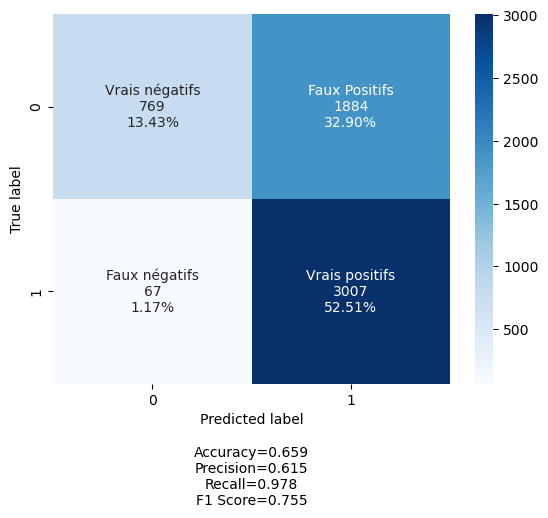

AUC: 0.75


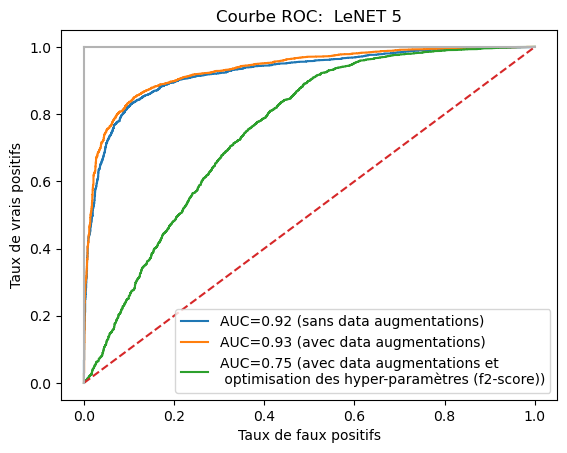

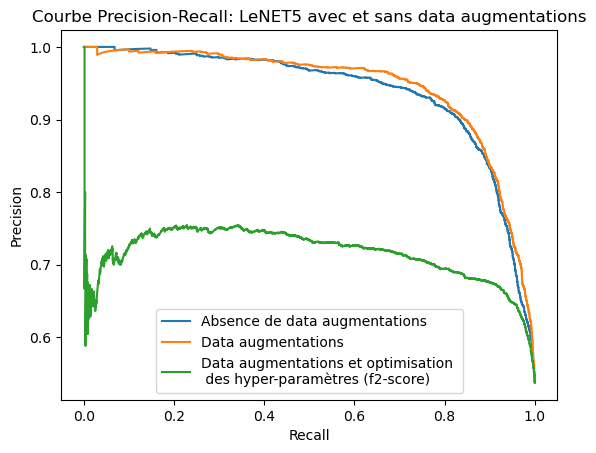

In [42]:
recall_best = history_best.history['recall_m']
val_recall_best = history_best.history['val_recall_m']

accuracy_best = history_best.history['Accuracy']
val_accuracy_best = history_best.history['val_Accuracy']

precision_best = history_best.history['precision_m']
val_precision_best = history_best.history['val_precision_m']

f1_best = history_best.history['f1_m']
val_f1_best = history_best.history['val_f1_m']

f2_best = history_best.history['f2_m']
val_f2_best = history_best.history['val_f2_m']

loss_best = history_best.history['loss']
val_loss_best = history_best.history['val_loss']

epochs_best = range(1, len(recall_best) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_best, loss_best, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_best, val_loss_best, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_best, accuracy_best, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_best, val_accuracy_best, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_best, precision_best, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_best, val_precision_best, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_best, recall_best, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_best, val_recall_best, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_best, f1_best, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_best, val_f1_best, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_best, f2_best, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_best, val_f2_best, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()

plt.savefig("loss_lenet5_bestf2.png")

plt.show()

loss_best_train, accuracy_best_train, recall_best_train, precision_best_train, f1score_best_train, f2score_best_train = best_model.evaluate(
    X_train_crop_permute.numpy(), Y_train_crop.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_best_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_best_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_best_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_best_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_best_train, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_best_train, 3)))

loss_best, accuracy_best, recall_best, precision_best, f1score_best, f2score_best = best_model.evaluate(
    X_test_crop_permute.numpy(), Y_test_crop.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_best, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_best, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_best, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_best, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_best, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_best, 3)))

best_predict = best_model.predict(X_test_crop_permute.numpy())
best_y_pred = (np.squeeze(best_predict) > 0.5).astype("int32")

uni_best, compteur_best = np.unique(best_y_pred, return_counts=True)
res_best = dict(zip(uni_best, compteur_best))
print("Nombre d'images prédites avec panneaux: {}".format(res_best[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best[0]))

r = confusion_matrix(Y_test_crop, best_y_pred)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      save="confusion_matrix_lenet5_bestf2.png"
                      )

FPR_best, TPR_best, thresholds_keras_best = roc_curve(
    Y_test_crop.numpy(), best_predict)
AUC_best = auc(FPR_best, TPR_best)
print("AUC: {}".format(round(AUC_best, 2)))

plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot(FPR_best, TPR_best, label="AUC="+str(round(AUC_best, 2)) +
         " (avec data augmentations et \n optimisation des hyper-paramètres (f2-score))")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.savefig("ROC_lenet5_bestf2.png")
plt.show()

prec_best, rec_best, thresholds_keras_best = precision_recall_curve(Y_test_crop.numpy(), best_predict)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, label="Data augmentations")
ax.plot(rec_best, prec_best, label="Data augmentations et optimisation \n des hyper-paramètres (f2-score)")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.savefig("prec_recall_lenet5_bestf2.png")
plt.show()

## Optimisation par rapport au f1-score

In [43]:
# learnRate = [1e-2, 1e-3, 1e-4]
# momentum = [0.9, 0.99]
# dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# batchSize = [4, 8, 16, 32, 64, 128, 256]
# epochs = [10, 20, 30, 40, 50]

# grid = dict(
#     learnRate=learnRate,
#     momentum=momentum,
#     dropout1=dropout1,
#     dropout2=dropout2,
#     dropout3=dropout3,
#     dropout4=dropout4,
#     batch_size=batchSize,
#     epochs=epochs
# )

# modelf1 = KerasClassifier(build_fn=buildModel, verbose=1)
# # n_iter: nombre de modèles entrainés
# searcher_f1 = RandomizedSearchCV(
#     estimator=modelf1, cv=5, n_iter=30, param_distributions=grid, scoring="f1")
# searchResults_f1 = searcher_f1.fit(
#     X_train_crop_permute.numpy(), Y_train_crop.numpy())

In [44]:
# # summarize grid search information
# bestScore_f1 = searchResults_f1.best_score_
# bestParams_f1 = searchResults_f1.best_params_
# print("[INFO] best score is {} using {}".format(round(bestScore_f1, 3),
#                                                 bestParams_f1))

# print(searchResults_f1.cv_results_["mean_test_score"])

In [45]:
best_model1= buildModel(learnRate=0.01, dropout1=0.1, dropout2=0.6,
                        dropout3=0.3, dropout4=0.8, momentum=0.9)

history_best1 = best_model1.fit(x=X_train_crop_permute.numpy(), y=Y_train_crop.numpy(),
                              validation_data=(
                                  X_test_crop_permute.numpy(), Y_test_crop.numpy()),
                              batch_size=32,
                              epochs=40)


Epoch 1/40
716/716 [==============================] - 14s 18ms/step - loss: 0.6299 - Accuracy: 0.6697 - recall_m: 0.7192 - precision_m: 0.6791 - f1_m: 0.6920 - f2_m: 0.7063 - val_loss: 0.4754 - val_Accuracy: 0.7948 - val_recall_m: 0.8909 - val_precision_m: 0.7666 - val_f1_m: 0.8197 - val_f2_m: 0.8596
Epoch 2/40
716/716 [==============================] - 12s 17ms/step - loss: 0.5551 - Accuracy: 0.7454 - recall_m: 0.7743 - precision_m: 0.7535 - f1_m: 0.7582 - f2_m: 0.7664 - val_loss: 0.4508 - val_Accuracy: 0.8118 - val_recall_m: 0.8581 - val_precision_m: 0.8035 - val_f1_m: 0.8260 - val_f2_m: 0.8439
Epoch 3/40
716/716 [==============================] - 12s 16ms/step - loss: 0.5317 - Accuracy: 0.7627 - recall_m: 0.7890 - precision_m: 0.7736 - f1_m: 0.7754 - f2_m: 0.7820 - val_loss: 0.4355 - val_Accuracy: 0.8147 - val_recall_m: 0.8556 - val_precision_m: 0.8095 - val_f1_m: 0.8284 - val_f2_m: 0.8436
Epoch 4/40
716/716 [==============================] - 12s 16ms/step - loss: 0.5201 - Accuracy:

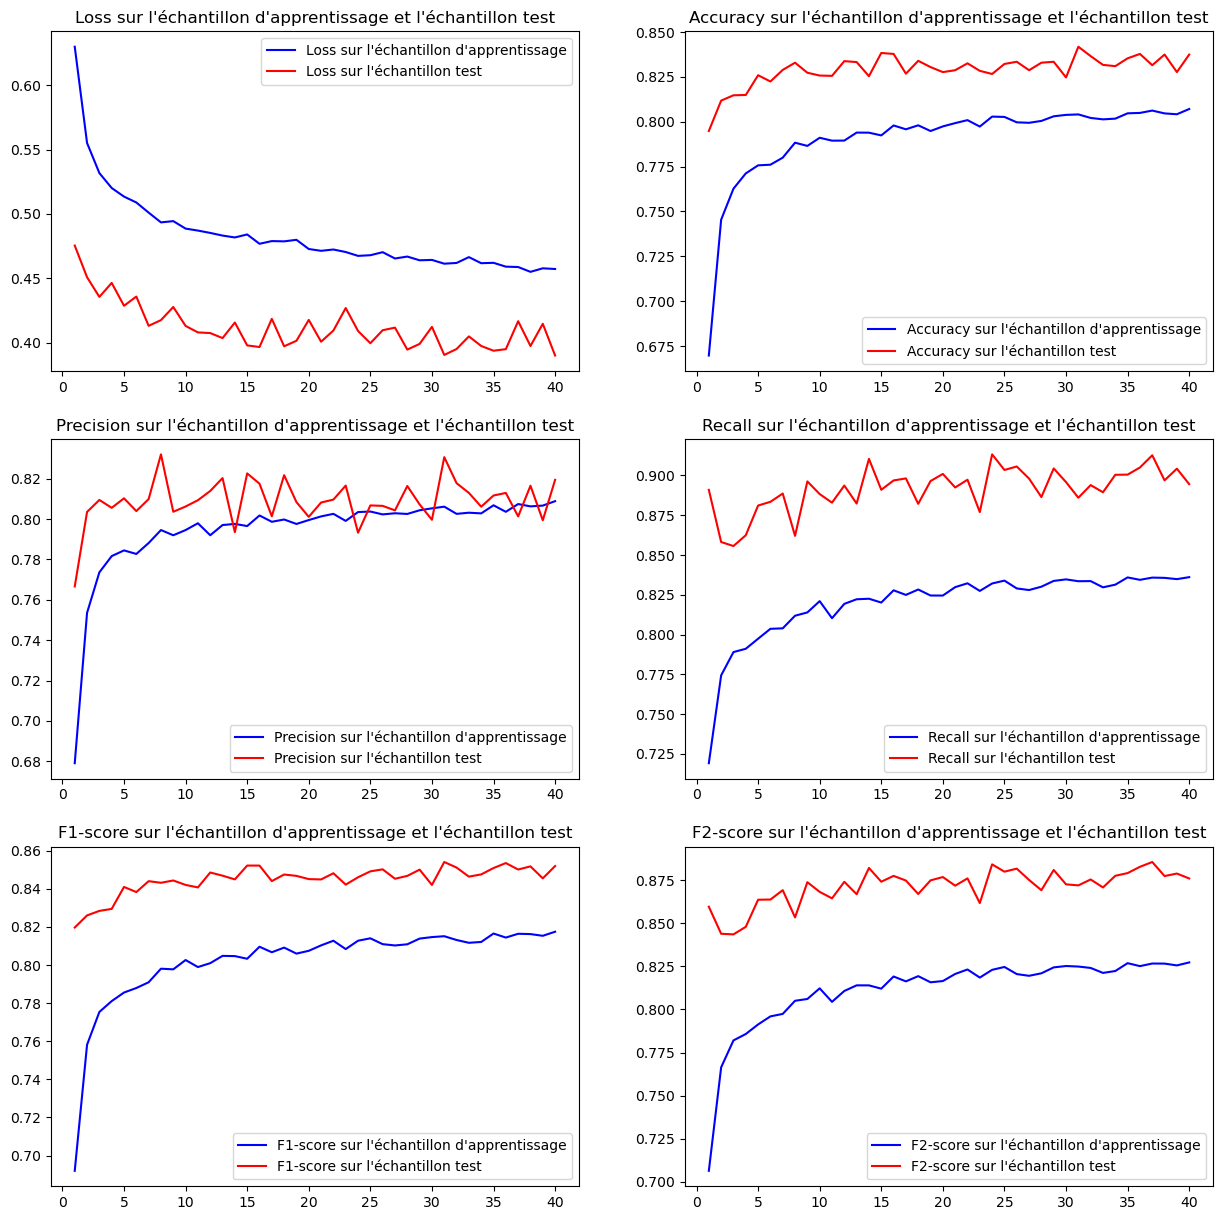

Loss sur l'échantillon train: 0.402
Accuracy sur l'échantillon train: 0.831
Recall sur l'échantillon train: 0.849
Precision sur l'échantillon train: 0.837
F1-score sur l'échantillon train: 0.839
F2-score sur l'échantillon train: 0.844
Loss sur l'échantillon test: 0.39
Accuracy sur l'échantillon test: 0.837
Recall sur l'échantillon test: 0.894
Precision sur l'échantillon test: 0.819
F1-score sur l'échantillon test: 0.852
F2-score sur l'échantillon test: 0.876
179/179 [==============================] - 1s 5ms/step
Nombre d'images prédites avec panneaux: 3363
Nombre d'images prédites sans panneau: 2364
AUC: 0.91


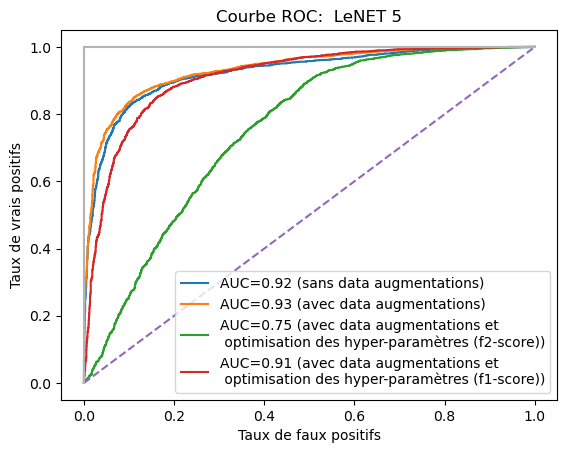

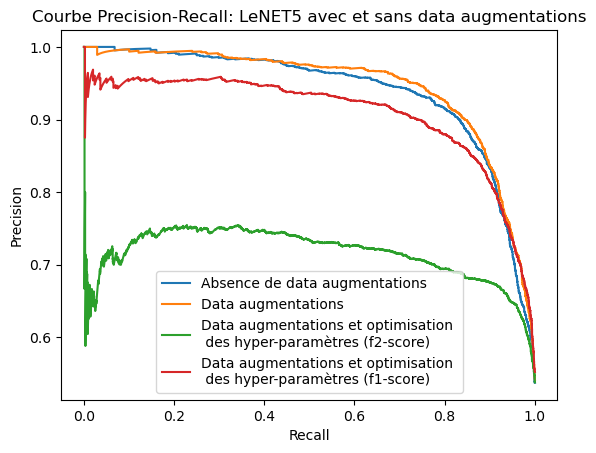

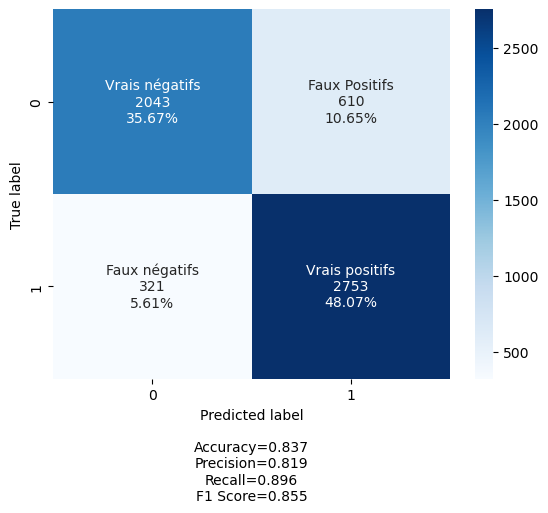

In [46]:
recall_best1 = history_best1.history['recall_m']
val_recall_best1 = history_best1.history['val_recall_m']

accuracy_best1 = history_best1.history['Accuracy']
val_accuracy_best1 = history_best1.history['val_Accuracy']

precision_best1 = history_best1.history['precision_m']
val_precision_best1 = history_best1.history['val_precision_m']

f1_best1 = history_best1.history['f1_m']
val_f1_best1 = history_best1.history['val_f1_m']

f2_best1 = history_best1.history['f2_m']
val_f2_best1 = history_best1.history['val_f2_m']

loss_best1 = history_best1.history['loss']
val_loss_best1 = history_best1.history['val_loss']

epochs_best1 = range(1, len(recall_best1) + 1)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(epochs_best1, loss_best1, 'b', label="Loss sur l'échantillon d'apprentissage")
axs[0, 0].plot(epochs_best1, val_loss_best1, 'b', label="Loss sur l'échantillon test", color="red")
axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 0].legend()

axs[0, 1].plot(epochs_best1, accuracy_best1, 'b', label="Accuracy sur l'échantillon d'apprentissage")
axs[0, 1].plot(epochs_best1, val_accuracy_best1, 'b', label="Accuracy sur l'échantillon test", color="red")
axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
axs[0, 1].legend()

axs[1, 0].plot(epochs_best1, precision_best1, 'b', label="Precision sur l'échantillon d'apprentissage")
axs[1, 0].plot(epochs_best1, val_precision_best1, 'b', label="Precision sur l'échantillon test", color="red")
axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 0].legend()

axs[1, 1].plot(epochs_best1, recall_best1, 'b', label="Recall sur l'échantillon d'apprentissage")
axs[1, 1].plot(epochs_best1, val_recall_best1, 'b', label="Recall sur l'échantillon test", color="red")
axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
axs[1, 1].legend()

axs[2, 0].plot(epochs_best1, f1_best1, 'b', label="F1-score sur l'échantillon d'apprentissage")
axs[2, 0].plot(epochs_best1, val_f1_best1, 'b', label="F1-score sur l'échantillon test", color="red")
axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 0].legend()

axs[2, 1].plot(epochs_best1, f2_best1, 'b', label="F2-score sur l'échantillon d'apprentissage")
axs[2, 1].plot(epochs_best1, val_f2_best1, 'b', label="F2-score sur l'échantillon test", color="red")
axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
axs[2, 1].legend()

plt.savefig("loss_lenet5_bestf1.png")
plt.show()

loss_best1_train, accuracy_best1_train, recall_best1_train, precision_best1_train, f1score_best1_train, f2score_best1_train = best_model1.evaluate(
    X_train_crop_permute.numpy(), Y_train_crop.numpy(), verbose=0)
print("Loss sur l'échantillon train: {}".format(round(loss_best1_train, 3)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_best1_train, 3)))
print("Recall sur l'échantillon train: {}".format(round(recall_best1_train, 3)))
print("Precision sur l'échantillon train: {}".format(round(precision_best1_train, 3)))
print("F1-score sur l'échantillon train: {}".format(round(f1score_best1_train, 3)))
print("F2-score sur l'échantillon train: {}".format(round(f2score_best1_train, 3)))

loss_best1, accuracy_best1, recall_best1, precision_best1, f1score_best1, f2score_best1 = best_model1.evaluate(
    X_test_crop_permute.numpy(), Y_test_crop.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_best1, 3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_best1, 3)))
print("Recall sur l'échantillon test: {}".format(round(recall_best1, 3)))
print("Precision sur l'échantillon test: {}".format(round(precision_best1, 3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_best1, 3)))
print("F2-score sur l'échantillon test: {}".format(round(f2score_best1, 3)))

best_predict1 = best_model1.predict(X_test_crop_permute.numpy())
best_y_pred1 = (np.squeeze(best_predict1) > 0.5).astype("int32")

uni_best1, compteur_best1 = np.unique(best_y_pred1, return_counts=True)
res_best1 = dict(zip(uni_best1, compteur_best1))
print("Nombre d'images prédites avec panneaux: {}".format(res_best1[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best1[0]))

FPR_best1, TPR_best1, thresholds_keras_best1 = roc_curve(
    Y_test_crop.numpy(), best_predict1)
AUC_best1 = auc(FPR_best1, TPR_best1)
print("AUC: {}".format(round(AUC_best1, 2)))

plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC, 2)) +
         " (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC=" +
         str(round(AUC_augmente, 2))+" (avec data augmentations)")
plt.plot(FPR_best, TPR_best, label="AUC="+str(round(AUC_best, 2)) +
         " (avec data augmentations et \n optimisation des hyper-paramètres (f2-score))")
plt.plot(FPR_best1, TPR_best1, label="AUC="+str(round(AUC_best1, 2)) +
         " (avec data augmentations et \n optimisation des hyper-paramètres (f1-score))")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.savefig("ROC_lenet5_bestf1.png")
plt.show()


prec_best1, rec_best1, thresholds_keras_best1 = precision_recall_curve(Y_test_crop.numpy(), best_predict1)

fig, ax = plt.subplots()
ax.plot(rec, prec, label="Absence de data augmentations")
ax.plot(rec_augmente, prec_augmente, label="Data augmentations")
ax.plot(rec_best, prec_best, label="Data augmentations et optimisation \n des hyper-paramètres (f2-score)")
ax.plot(rec_best1, prec_best1, label="Data augmentations et optimisation \n des hyper-paramètres (f1-score)")

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: LeNET5 avec et sans data augmentations')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.legend(loc=0)
plt.savefig("prec_recall_lenet5_bestf1.png")
plt.show()

r = confusion_matrix(Y_test_crop, best_y_pred1)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      save="confusion_matrix_lenet5_bestf1.png"
                      )

In [47]:
best_model1.save('lenet5_optim.h5')
#load_model = models.load_model('lenet5_optim.h5')

# TSNE Visualisation

In [75]:
print(best_model1.summary())

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d_84 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                                 
 dropout_168 (Dropout)       (None, 14, 14, 6)         0         
                                                                 
 conv2d_85 (Conv2D)          (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_85 (Avera  (None, 5, 5, 16)         0         
 gePooling2D)                                                    
                                                                 
 dropout_169 (Dropout)       (None, 5, 5, 16)        

In [92]:
test_dataset_tsne = CustomImageDataset_path(path_test, "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google2/img/",
                                            transform=transforms.Compose([
                                                transforms.Resize(28),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean_test.tolist(),
                                                                     std=std_test.tolist()),
                                            ]))

test_dataloader_tsne = DataLoader(test_dataset_tsne, batch_size=5727, shuffle=True)
X_tsne, Y_tsne, path_tsne = next(iter(test_dataloader_tsne))
X_tsne_permute = X_tsne.permute(0, 2, 3, 1)


In [94]:
def embedding(data):
    model = Model(inputs=best_model1.input, outputs=best_model1.get_layer('conv2d_84').output)
    out=model.predict(data)
    model = Model(inputs=best_model1.get_layer('conv2d_84').output, outputs=best_model1.get_layer('average_pooling2d_84').output)
    out=model.predict(out)
    model = Model(inputs=best_model1.get_layer('average_pooling2d_84').output, outputs=best_model1.get_layer('dropout_168').output)
    out=model.predict(out)
    model = Model(inputs=best_model1.get_layer('dropout_168').output, outputs=best_model1.get_layer('conv2d_85').output)
    out=model.predict(out)
    model = Model(inputs=best_model1.get_layer('conv2d_85').output, outputs=best_model1.get_layer('average_pooling2d_85').output)
    out=model.predict(out)
    model = Model(inputs=best_model1.get_layer('average_pooling2d_85').output, outputs=best_model1.get_layer('dropout_169').output)
    out=model.predict(out)
    model = Model(inputs=best_model1.get_layer('dropout_169').output, outputs=best_model1.get_layer('flatten_42').output)
    out=model.predict(out)
    return out


In [95]:
features=embedding(X_tsne_permute.numpy())

179/179 [==============================] - 0s 1ms/step


In [106]:
tsne = TSNE(n_components=2, perplexity=50).fit_transform(features)
#The larger the perplexity, the more non-local information will be retained in the dimensionality reduction result.

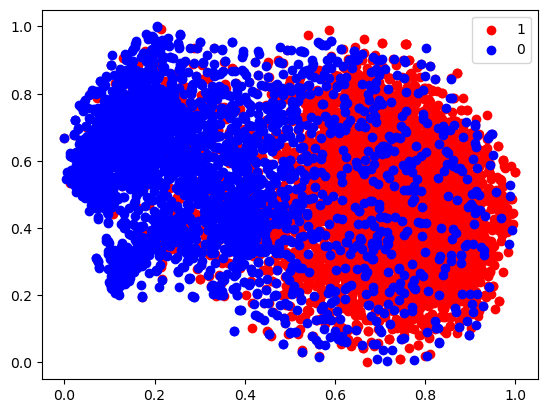

Building the T-SNE plot: 100%|██████████| 5727/5727 [00:21<00:00, 262.55it/s]


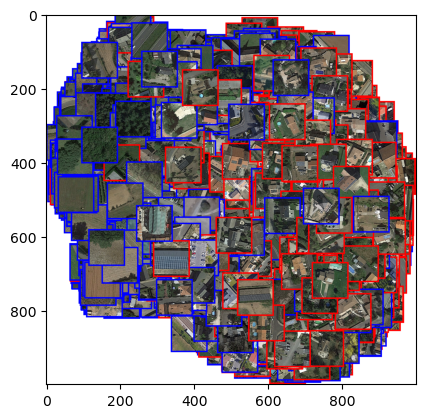

In [107]:
visualize_tsne(tsne, path_tsne, Y_tsne.numpy())